![terms on object recognition](./terms_on_object_recognition.png)

ClassificationÎ™®Îç∏ ÎåÄÏã† ÏúÑÏ≤òÎüº outputÏùÑ Ï∂îÍ∞ÄÌï¥ÏÑú localization Î™®Îç∏ÏùÑ Íµ¨ÏÑ±ÌïúÎã§Í≥† ÌñàÏùÑ Îïå, Ï†ÑÏ≤¥Ï†ÅÏù∏ Î™®Îç∏ÏùÑ kerasÎ°ú Í∞ÑÎã®Ìûà ÎßåÎì§Ïñ¥Î¥ÖÏãúÎã§.

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

output_num = 1+4+3 # object_prob 1, bbox coord 4, class_prob 3

input_tensor = keras.layers.Input(shape=(224, 224, 3), name='image')
base_model = keras.applications.resnet.ResNet50(
    input_tensor=input_tensor,
    include_top=False,    
    weights='imagenet',
    pooling=None,
)


x = base_model.output
# CNNÏùÑ ÌôúÏö©Ìï¥ÏÑú ÏòàÏ∏°Í∞íÏùÑ ÏÑ†Ïñ∏Ìï¥Ï£ºÏÑ∏Ïöî
# localize_modelÏùÑ ÎßåÎì§Ïñ¥Ï£ºÏÑ∏Ïöî
x = base_model.output
x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
output_tensor = layers.Dense(output_num, activation='sigmoid')(x)

localize_model = keras.models.Model(inputs=base_model.input, outputs=output_tensor)

localize_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

### ÏûêÏú®Ï£ºÌñâ Î≥¥Ï°∞Ïû•Ïπò (1) KITTI Îç∞Ïù¥ÌÑ∞ÏÖã

ÏûêÏú®Ï£ºÌñâ Î≥¥Ï°∞Ïû•Ïπò object detection ÏöîÍµ¨ÏÇ¨Ìï≠

* ÏÇ¨ÎûåÏù¥ Ïπ¥Î©îÎùºÏóê Í∞êÏßÄÎêòÎ©¥ Ï†ïÏßÄ
* Ï∞®ÎüâÏù¥ ÏùºÏ†ï ÌÅ¨Í∏∞ Ïù¥ÏÉÅÏúºÎ°ú Í∞êÏßÄÎêòÎ©¥ Ï†ïÏßÄ

In [46]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

print('Ïäù=3')

Ïäù=3


ÏïÑÎûò ÏΩîÎìúÎ•º ÌÜµÌï¥ÏÑú KITTI Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Îã§Ïö¥Î°úÎìúÌï¥ Ï£ºÏÑ∏Ïöî. 30-40Î∂Ñ Ï†ïÎèÑ Í±∏Î¶ΩÎãàÎã§.

In [47]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('Ïäù=3')

Ïäù=3


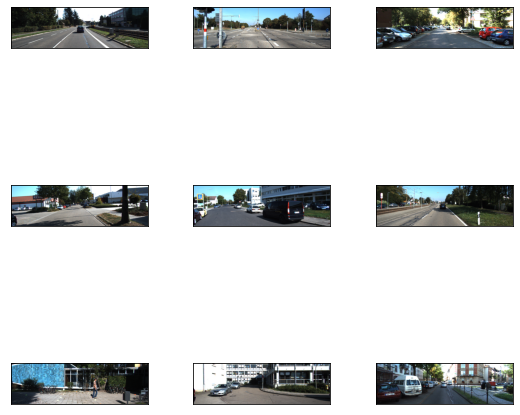

In [48]:
_ = tfds.show_examples(ds_train, ds_info)

In [49]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

In [50]:
# ÌÅ¥ÎûòÏä§ Î™©Î°ù Ï∂îÏ∂ú
class_names = ds_info.features['objects']['type'].names

# ÌÅ¥ÎûòÏä§ Î™©Î°ù Ï∂úÎ†•
print("KITTI Îç∞Ïù¥ÌÑ∞ÏÖã Í∞ùÏ≤¥ Ïú†Ìòï ÌÅ¥ÎûòÏä§ Î™©Î°ù:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

KITTI Îç∞Ïù¥ÌÑ∞ÏÖã Í∞ùÏ≤¥ Ïú†Ìòï ÌÅ¥ÎûòÏä§ Î™©Î°ù:
0: Car
1: Van
2: Truck
3: Pedestrian
4: Person_sitting
5: Cyclist
6: Tram
7: Misc


### ÏûêÏú®Ï£ºÌñâ Î≥¥Ï°∞Ïû•Ïπò (2) Îç∞Ïù¥ÌÑ∞ ÏßÅÏ†ë ÌôïÏù∏ÌïòÍ∏∞

Ïù¥Î≤àÏóêÎäî Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏßÅÏ†ë ÌôïÏù∏ÌïòÎäî ÏãúÍ∞ÑÏùÑ Í∞ñÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§. ds_train.take(1)ÏùÑ ÌÜµÌï¥ÏÑú Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÌïòÎÇòÏî© ÎΩëÏïÑÎ≥º Ïàò ÏûàÎäî sampleÏùÑ ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Î†áÍ≤å ÎΩëÏùÄ Îç∞Ïù¥ÌÑ∞ÏóêÎäî image Îì±Ïùò Ï†ïÎ≥¥Í∞Ä Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏäµÎãàÎã§.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 1.94, -1.79, -1.31, -1.77, -1.74, -1.48, -1.7 ,  1.63, -1.62],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.00266667, 0.02610306, 0.44632   , 0.34214172],
       [0.19072   , 0.57321256, 0.5009867 , 0.7091707 ],
       [0.17802666, 0.25784218, 0.48936   , 0.39426732],
       [0.30624   , 0.5499034 , 0.49776   , 0.6313768 ],
       [0.35048   , 0.533285  , 0.50189334, 0.59191626],
       [0.37288   , 0.39694846, 0.50405335, 0.44279388],
       [0.38906667, 0.5287842 , 0.53874665, 0.5755072 ],
       [0.41938666, 0.42517713, 0.50744   , 0.45710143],
       [0.44536   , 0.5109903 , 0.51162666, 0.533752  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.38, 1.53, 3.58],
       [1.49, 1.65, 4.06],
       [1.48, 1.58, 3.98],
       [1.44, 1.56, 3.76],
       [1.53,

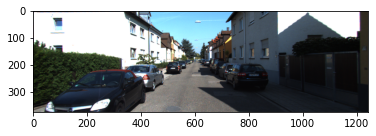

(1242, 375)

In [51]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()
img.size

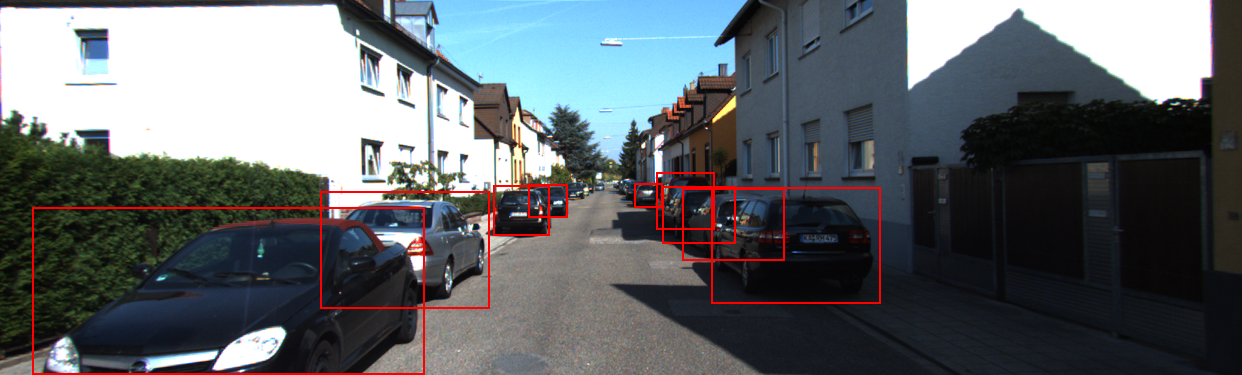

In [52]:
# Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê Î∞îÏö¥Îî© Î∞ïÏä§Î•º Í∑∏Î†§ ÌôîÎ©¥Ïóê ÌëúÏãúÌï¥ Ï£ºÏÑ∏Ïöî.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # Î∞îÏö¥Îî© Î∞ïÏä§ Ï¢åÌëú(x_min, x_max, y_min, y_max) Íµ¨ÌïòÍ∏∞
    width, height = input_image.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # Î∞îÏö¥Îî© Î∞ïÏä§ Í∑∏Î¶¨Í∏∞
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### RetinaNet

1-stage detector Î™®Îç∏Ïù∏ YOLOÏôÄ SSDÎäî 2-stage detectorÏù∏ Faster-RCNN Îì±Î≥¥Îã§ ÏÜçÎèÑÎäî Îπ†Î•¥ÏßÄÎßå ÏÑ±Îä•Ïù¥ ÎÇÆÏùÄ Î¨∏Ï†úÎ•º Í∞ÄÏßÄÍ≥† ÏûàÏóàÏäµÎãàÎã§. Ïù¥Î•º Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú RetinaNetÏóêÏÑúÎäî **focal lossÏôÄ FPN(Feature Pyramid Network) Î•º Ï†ÅÏö©Ìïú ÎÑ§Ìä∏ÏõåÌÅ¨Î•º ÏÇ¨Ïö©**Ìï©ÎãàÎã§.

#### Focal Loss
* Î¨ºÏ≤¥Î•º Î∞∞Í≤ΩÎ≥¥Îã§ Îçî Ïûò ÌïôÏäµÌïòÏûê == Î¨ºÏ≤¥Ïù∏ Í≤ΩÏö∞ LossÎ•º ÏûëÍ≤å ÎßåÎì§Ïûê
* Hard Negative Mining(negativesÏôÄ positivesÏùò ÎπÑÏú®Ïù¥ 3:1Ïù¥ ÎêòÎèÑÎ°ù lossÍ∞Ä ÌÅ∞ negativesÎ•º ÏÑ†ÌÉùÌï¥ÏÑú ÏÇ¨Ïö©)Í≥º ÎπÑÏä∑Ìïú Ïó≠Ìï†ÏùÑ ÏàòÌñâÌïúÎã§.

![focal loss](./focal_loss.png)

Focal lossÎäî Ïö∞Î¶¨Í∞Ä ÎßéÏù¥ ÏÇ¨Ïö©Ìï¥ÏôîÎçò ÍµêÏ∞® ÏóîÌä∏Î°úÌîºÎ•º Í∏∞Î∞òÏúºÎ°ú ÎßåÎì§Ïñ¥Ï°åÏäµÎãàÎã§. ÏúÑ Í∑∏Î¶ºÏùÑ Î≥¥Î©¥ Focal lossÎäî Í∑∏Ï†Ä ÍµêÏ∞® ÏóîÌä∏Î°úÌîº CEÏùò ÏïûÎã®Ïóê Í∞ÑÎã®Ìûà (1‚àíùëùùë°)^ùõæÎùºÎäî modulating factorÎ•º Î∂ôÏó¨Ï£ºÏóàÏäµÎãàÎã§.

ÍµêÏ∞® ÏóîÌä∏Î°úÌîºÏùò Í∞úÌòïÏùÑ Î≥¥Î©¥ ground truth classÏóê ÎåÄÌïú ÌôïÎ•†Ïù¥ ÎÜíÏúºÎ©¥ Ïûò Î∂ÑÎ•òÎêú Í≤ÉÏúºÎ°ú ÌåêÎã®ÎêòÎØÄÎ°ú ÏÜêÏã§Ïù¥ Ï§ÑÏñ¥ÎìúÎäî Í≤ÉÏùÑ Î≥º Ïàò ÏûàÏäµÎãàÎã§. ÌïòÏßÄÎßå ÌôïÎ•†Ïù¥ 1Ïóê Îß§Ïö∞ Í∞ÄÍπùÏßÄ ÏïäÏùÄ Ïù¥ÏÉÅ ÏÉÅÎãπÌûà ÌÅ∞ ÏÜêÏã§Î°ú Ïù¥Ïñ¥ÏßÄÎäîÎç∞Ïöî.

Ïù¥ ÏÉÅÌô©ÏùÄ Î¨ºÏ≤¥ Í≤ÄÏ∂ú Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ§Îäî Í≥ºÏ†ïÏóêÏÑú Î¨∏Ï†úÍ∞Ä Îê† Ïàò ÏûàÏäµÎãàÎã§. ÎåÄÎ∂ÄÎ∂ÑÏùò Ïù¥ÎØ∏ÏßÄÏóêÏÑúÎäî Î¨ºÏ≤¥Î≥¥Îã§ Î∞∞Í≤ΩÏù¥ ÎßéÏäµÎãàÎã§. Îî∞ÎùºÏÑú Ïù¥ÎØ∏ÏßÄÎäî Í∑πÎã®Ï†ÅÏúºÎ°ú Î∞∞Í≤ΩÏùò classÍ∞Ä ÎßéÏùÄ class imbalanced dataÎùºÍ≥† Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Î†áÍ≤å ÎÑàÎ¨¥ ÎßéÏùÄ Î∞∞Í≤Ω classÏóê ÏïïÎèÑÎêòÏßÄ ÏïäÎèÑÎ°ù modulating factorÎ°ú ÏÜêÏã§ÏùÑ Ï°∞Ï†àÌï¥Ï§çÎãàÎã§. ùõæÎ•º 0ÏúºÎ°ú ÏÑ§Ï†ïÌïòÎ©¥ modulating factor(1‚àíùëùùë°)^ùõæÍ∞Ä 1Ïù¥ ÎêòÏñ¥ ÏùºÎ∞òÏ†ÅÏù∏ ÍµêÏ∞® ÏóîÌä∏Î°úÌîºÍ∞Ä ÎêòÍ≥† ùõæÍ∞Ä Ïª§ÏßàÏàòÎ°ù modulatingÏù¥ Í∞ïÌïòÍ≤å Ï†ÅÏö©ÎêòÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

#### FPN(Feature Pyramid Network)

![feature pyramid network](./feature_pyramid_network.png)

FPNÏùÄ ÌäπÏÑ±ÏùÑ ÌîºÎùºÎØ∏ÎìúÏ≤òÎüº ÏåìÏïÑÏÑú ÏÇ¨Ïö©ÌïòÎäî Î∞©ÏãùÏûÖÎãàÎã§. CNN Î∞±Î≥∏ ÎÑ§Ìä∏ÏõåÌÅ¨ÏóêÏÑúÎäî Îã§ÏñëÌïú Î†àÏù¥Ïñ¥Ïùò Í≤∞Í≥ºÍ∞íÏùÑ ÌäπÏÑ± Îßµ(feature map)ÏúºÎ°ú ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Îïå Ïª®Î≥ºÎ£®ÏÖò Ïó∞ÏÇ∞ÏùÄ Ïª§ÎÑêÏùÑ ÌÜµÌï¥ ÏùºÏ†ïÌïú ÏòÅÏó≠ÏùÑ Î≥¥Í≥† Î™á Í∞úÏùò Ïà´ÏûêÎ°ú ÏöîÏïΩÌï¥ ÎÇ¥Í∏∞ ÎïåÎ¨∏Ïóê, ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÏÉùÍ∞ÅÌïòÎ©¥ ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏôÄ Î®º Î™®Îç∏Ïùò Îí∑Ï™ΩÏùò ÌäπÏÑ± ÎßµÏùºÏàòÎ°ù ÌïòÎÇòÏùò "ÏÖÄ(cell)"Ïù¥ ÎÑìÏùÄ Ïù¥ÎØ∏ÏßÄ ÏòÅÏó≠Ïùò Ï†ïÎ≥¥Î•º Îã¥Í≥† ÏûàÍ≥†, ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏôÄ Í∞ÄÍπåÏö¥ ÏïûÏ™Ω Î†àÏù¥Ïñ¥Ïùò ÌäπÏÑ± ÎßµÏùºÏàòÎ°ù Ï¢ÅÏùÄ Î≤îÏúÑÏùò Ï†ïÎ≥¥Î•º Îã¥Í≥† ÏûàÏäµÎãàÎã§. Ïù¥Î•º receptive fieldÎùºÍ≥† Ìï©ÎãàÎã§. Î†àÏù¥Ïñ¥Í∞Ä ÍπäÏñ¥Ïßà ÏàòÎ°ù poolingÏùÑ Í±∞Ï≥ê ÎÑìÏùÄ Î≤îÏúÑÏùò Ï†ïÎ≥¥(receptive field)Î•º Í∞ñÍ≤å ÎêòÎäî Í≤ÉÏûÖÎãàÎã§.

FPNÏùÄ Î∞±Î≥∏Ïùò Ïó¨Îü¨ Î†àÏù¥Ïñ¥Î•º ÌïúÍ∫ºÎ≤àÏóê Ïì∞Í≤†Îã§ÎùºÎäîÎç∞Ïóê ÏùòÏùòÍ∞Ä ÏûàÏäµÎãàÎã§. SSDÍ∞Ä Í∞Å Î†àÏù¥Ïñ¥Ïùò ÌäπÏÑ± ÎßµÏóêÏÑú Îã§ÏñëÌïú ÌÅ¨Í∏∞Ïóê ÎåÄÌïú Í≤∞Í≥ºÎ•º ÏñªÎäî Î∞©ÏãùÏùÑ Ï∑®ÌñàÎã§Î©¥ RetinaNetÏóêÏÑúÎäî receptive fieldÍ∞Ä ÎÑìÏùÄ Îí∑Ï™ΩÏùò ÌäπÏÑ± ÎßµÏùÑ upsampling(ÌôïÎåÄ)ÌïòÏó¨ ÏïûÎã®Ïùò ÌäπÏÑ± ÎßµÍ≥º ÎçîÌï¥ÏÑú ÏÇ¨Ïö©ÌñàÏäµÎãàÎã§. Î†àÏù¥Ïñ¥Í∞Ä ÍπäÏñ¥ÏßàÏàòÎ°ù feature mapÏùò ùë§,‚ÑéÎ∞©Ìñ•Ïùò receptive fieldÍ∞Ä ÎÑìÏñ¥ÏßÄÎäî Í≤ÉÏù∏Îç∞, ÎÑìÍ≤å Î≥¥Îäî Í≤ÉÍ≥º Ï¢ÅÍ≤å Î≥¥Îäî Í≤ÉÏùÑ Í∞ôÏù¥ Ïì∞Í≤†Îã§Îäî Î™©Ï†ÅÏù∏ Í±∞Ï£†.

### Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ

#### Îç∞Ïù¥ÌÑ∞ ÌååÏù¥ÌîÑ ÎùºÏù∏

Î®ºÏ†Ä Ï£ºÏñ¥ÏßÑ KITTI Îç∞Ïù¥ÌÑ∞Î•º ÌïôÏäµÏóê ÎßûÎäî ÌòïÌÉúÎ°ú Î∞îÍæ∏Ïñ¥ Ï£ºÏñ¥Ïïº Ìï©ÎãàÎã§. Ïù¥Îïå ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞ ÌååÏù¥ÌîÑÎùºÏù∏ÏùÑ Íµ¨Ï∂ïÌï©ÎãàÎã§.

Îç∞Ïù¥ÌÑ∞ ÌååÏù¥ÌîÑÎùºÏù∏ÏùÄ Ï¥ù 4Îã®Í≥ÑÎ°ú Ïù¥Î£®Ïñ¥ÏßëÎãàÎã§.

1. xÏôÄ yÏ¢åÌëú ÏúÑÏπò ÍµêÏ≤¥
2. Î¨¥ÏûëÏúÑÎ°ú ÏàòÌèâ Îí§ÏßëÍ∏∞(Flip)
3. Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞ Ï°∞Ï†ï Î∞è Ìå®Îî© Ï∂îÍ∞Ä
4. Ï¢åÌëúÍ≥ÑÎ•º [x_min, y_min, x_max, y_max]ÏóêÏÑú [x_min, y_min, width, height]ÏúºÎ°ú ÏàòÏ†ï
ÎèÖÎ¶ΩÏ†ÅÏù∏ Ìï®ÏàòÎ•º Í∞ÅÍ∞Å ÏûëÏÑ±Ìï©ÎãàÎã§.

In [53]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('Ïäù=3')

Ïäù=3


In [54]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('Ïäù=3')

Ïäù=3


Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º Î∞îÍøÄ ÎïåÎäî Í≥†Î†§Ìï† Ï†êÏù¥ ÏûàÏäµÎãàÎã§. Ïù¥ÎØ∏ÏßÄÏùò ÎπÑÏú®ÏùÄ Í∑∏ÎåÄÎ°ú Ïú†ÏßÄÎêòÏñ¥Ïïº ÌïòÍ≥†, Ïù¥ÎØ∏ÏßÄÏùò ÏµúÎåÄ/ÏµúÏÜå ÌÅ¨Í∏∞ÎèÑ Ï†úÌïúÌï¥Ïïº ÌïòÍ±∞Îì†Ïöî. Îòê Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î•º Î∞îÍæº ÌõÑÏóêÎèÑ ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú Î™®Îç∏Ïóê ÏûÖÎ†•ÎêòÎäî Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Îäî strideÏùò Î∞∞ÏàòÍ∞Ä ÎêòÎèÑÎ°ù ÎßåÎì§ Í±∞ÏòàÏöî.

ÏòàÎ•º Îì§Ïñ¥ 600x720 ÌÅ¨Í∏∞Ïùò Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÎã§Î©¥ 800x960 ÌÅ¨Í∏∞Î°ú Î∞îÍøÄ Ïàò ÏûàÏäµÎãàÎã§. Ïó¨Í∏∞Ïóê strideÎ•º 128Î°ú ÎÜìÏïÑ 800x960 ÌÅ¨Í∏∞Ïùò Ïù¥ÎØ∏ÏßÄÏóê Ìå®Îî©ÏùÑ ÎçîÌï¥ 896x1024 ÌÅ¨Í∏∞Ïùò Ïù¥ÎØ∏ÏßÄÎ°ú Î™®Îç∏Ïóê ÏûÖÎ†•ÌïòÍ≤†Îã§Îäî Ïù¥ÏïºÍπÅÎãàÎã§. Î™®Îç∏Ïóê ÏûÖÎ†•ÎêòÎäî Ïù¥ÎØ∏ÏßÄÏóêÎäî Í≤ÄÏ†ï ÌÖåÎëêÎ¶¨Í∞Ä ÏûàÍ≤†Íµ∞Ïöî!

Ïã§Ï†úÎ°ú ÏûÖÎ†•Ìï† Ïù¥ÎØ∏ÏßÄÎ•º Ïñ¥ÎñªÍ≤å Î∞îÍøÄÏßÄÎäî min_side, max_side, min_side_range, strideÎì±Ïóê ÏùòÌï¥ Í≤∞Ï†ïÎèºÏöî. Í∑∏Î¶¨Í≥† ÌïôÏäµÏù¥ ÏôÑÎ£åÎêú Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï† ÎïåÎäî ÏûÖÎ†•Ìï† Ïù¥ÎØ∏ÏßÄÎ•º Îã§ÏñëÌïú ÌÅ¨Í∏∞Î°ú Î∞îÍøÄ ÌïÑÏöîÎäî ÏóÜÏúºÎãà Î∂ÑÍ∏∞Ï≤òÎ¶¨Î•º Ìï¥Ï§çÎãàÎã§.

> RetinaNetÏóêÏÑú Ïù¥ÎØ∏ÏßÄÎ•º strideÏùò Î∞∞ÏàòÎ°ú ÏÑ§Ï†ïÌïòÎäî Ïù¥Ïú†Îäî Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§:  
**Ìö®Ïú®Ï†ÅÏù∏ ÌîºÏ≤ò Îßµ ÏÉùÏÑ±:** RetinaNetÏùÄ ÌîºÎùºÎØ∏Îìú ÌîºÏ≤ò ÎÑ§Ìä∏ÏõåÌÅ¨(FPN)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Îã§ÏñëÌïú ÌÅ¨Í∏∞Ïùò ÌîºÏ≤ò ÎßµÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§. Ïù¥ ÌîºÏ≤ò ÎßµÎì§ÏùÄ stride(Î≥¥Ìè≠) ÌÅ¨Í∏∞Î•º Í∏∞Ï§ÄÏúºÎ°ú Îã§Ïö¥ÏÉòÌîåÎßÅÎê©ÎãàÎã§. Îî∞ÎùºÏÑú ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Í∞Ä strideÏùò Î∞∞ÏàòÍ∞Ä ÎêòÎ©¥, ÌîºÏ≤ò ÎßµÏùò ÌÅ¨Í∏∞Í∞Ä Ï†ÅÏ†àÌïòÍ≤å ÎßûÏ∂∞Ï†∏ Í≥ÑÏÇ∞ Ìö®Ïú®ÏÑ±ÏùÑ ÎÜíÏùº Ïàò ÏûàÏäµÎãàÎã§.  
**Ï†ïÌôïÌïú ÏïµÏª§ Î∞ïÏä§ Îß§Ïπ≠:** RetinaNetÏùÄ Îã§ÏñëÌïú ÌÅ¨Í∏∞ÏôÄ ÎπÑÏú®Ïùò ÏïµÏª§ Î∞ïÏä§Î•º ÏÉùÏÑ±ÌïòÏó¨ Í∞ùÏ≤¥Î•º ÌÉêÏßÄÌï©ÎãàÎã§. Ïù¥ ÏïµÏª§ Î∞ïÏä§Îì§Ïù¥ ÌîºÏ≤ò ÎßµÏùò Í∞Å ÏúÑÏπòÏóê Î∞∞ÏπòÎêòÎäîÎç∞, Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Í∞Ä strideÏùò Î∞∞ÏàòÍ∞Ä ÎêòÎ©¥ ÏïµÏª§ Î∞ïÏä§Îì§Ïù¥ Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤¥Ïóê Í±∏Ï≥ê Í≥†Î•¥Í≤å Î∂ÑÌè¨ÌïòÍ≤å Îê©ÎãàÎã§. Ïù¥Îäî Í∞ùÏ≤¥ ÌÉêÏßÄ ÏÑ±Îä•ÏùÑ ÎÜíÏù¥Îäî Îç∞ ÎèÑÏõÄÏùÑ Ï§çÎãàÎã§.  
**Ìå®Îî© Î¨∏Ï†ú ÏµúÏÜåÌôî:** Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Í∞Ä strideÏùò Î∞∞ÏàòÍ∞Ä ÏïÑÎãê Í≤ΩÏö∞, ÎÑ§Ìä∏ÏõåÌÅ¨Îäî Ïù¥ÎØ∏ÏßÄ Í∞ÄÏû•ÏûêÎ¶¨Ïóê Ìå®Îî©ÏùÑ Ï∂îÍ∞ÄÌï¥Ïïº Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Îäî ÎÑ§Ìä∏ÏõåÌÅ¨Ïùò Í≥ÑÏÇ∞ Ìö®Ïú®ÏÑ±ÏùÑ Îñ®Ïñ¥Îú®Î¶¨Î©∞, ÌÉêÏßÄ ÏÑ±Îä•ÏóêÎèÑ ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ† Ïàò ÏûàÏäµÎãàÎã§. Îî∞ÎùºÏÑú Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º strideÏùò Î∞∞ÏàòÎ°ú ÏÑ§Ï†ïÌïòÎ©¥ Ïù¥Îü¨Ìïú Î¨∏Ï†úÎ•º ÏµúÏÜåÌôîÌï† Ïàò ÏûàÏäµÎãàÎã§.  
Ïù¥Îü¨Ìïú Ïù¥Ïú†Îì§Î°ú Ïù∏Ìï¥ RetinaNetÏóêÏÑú Ïù¥ÎØ∏ÏßÄÎ•º strideÏùò Î∞∞ÏàòÎ°ú ÏÑ§Ï†ïÌïòÎäî Í≤ÉÏù¥ Ï§ëÏöîÌï©ÎãàÎã§. 

In [55]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('Ïäù=3')

Ïäù=3


In [56]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], # Ï§ëÏã¨Ï†ê, w,hÍ≥ÑÏÇ∞
        axis=-1,
    )

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú Ï§ÄÎπÑÎêú Ìï®ÏàòÎì§ÏùÑ Ïó∞Í≤∞Ìï¥ Ï§çÎãàÎã§.

In [57]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox) 
    return image, bbox, class_id

print('Ïäù=3')

Ïäù=3


#### Ïù∏ÏΩîÎî©

One stage detectorÏóêÏÑúÎäî Anchor BoxÎùºÎäî Ï†ïÌï¥Ï†∏ ÏûàÎäî ÏúÑÏπò, ÌÅ¨Í∏∞, ÎπÑÏú® Ï§ëÏóê ÌïòÎÇòÎ°ú Î¨ºÏ≤¥Ïùò ÏúÑÏπòÍ∞Ä Í≤∞Ï†ïÎê©ÎãàÎã§. Í∑∏ÎûòÏÑú Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Anchor BoxÎ•º ÏÉùÏÑ±Ìï¥Ï§òÏïº Ìï©ÎãàÎã§. Anchor BoxÎ°ú ÏÉùÏÑ±ÎêòÎäî Í≤ÉÏùÄ Î¨ºÏ≤¥ ÏúÑÏπò ÌõÑÎ≥¥ÎùºÍ≥† ÏÉùÍ∞ÅÌïòÎ©¥ Îê©ÎãàÎã§. Î¨ºÏ≤¥ ÏúÑÏπòÎ•º Ï£ºÍ¥ÄÏãùÏù¥ ÏïÑÎãå Í∞ùÍ¥ÄÏãùÏúºÎ°ú ÌíÄÍ≤å ÌïòÎäî Í≤ÅÎãàÎã§.

ÏòàÎ•º Îì§Ïñ¥ 100Í∞úÏùò Anchor BoxÎ•º ÏÉùÏÑ±ÌñàÎã§Í≥† Í∞ÄÏ†ïÌïòÎ©¥ Ïù¥ÎØ∏ ÎßåÎì§Ïñ¥ÏßÑ 100Í∞úÏùò Anchor BoxÏóê Ìï¥ÎãπÌïòÏßÄ ÏïäÎäî ÏúÑÏπò, ÌÅ¨Í∏∞, ÎπÑÏú®Ïóê Î¨ºÏ≤¥Í∞Ä ÏûàÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. 100Í∞úÏùò Anchor BoxÏ§ë Í∞ÄÏû• Í∑ºÏ†ëÌïú ÌïòÎÇòÍ∞Ä ÏÑ†ÌÉùÏù¥ ÎêòÍ≤†Ï£†. Ïù¥Î†áÍ≤å ÏÑ†ÌÉùÎêú Anchor BoxÎ•º Í∏∞Ï¥àÎ°ú Ï†ïÌôïÌïú ÏúÑÏπòÎ•º Ï∞æÏïÑÎÉÖÎãàÎã§. Ï∂îÍ∞ÄÎ°ú Anchor BoxÎ°úÎ∂ÄÌÑ∞ ÏÉÅÌïòÏ¢åÏö∞Î°ú Îñ®Ïñ¥ÏßÑ Ï†ïÎèÑ, Í∞ÄÎ°ú ÏÑ∏Î°úÏùò ÌÅ¨Í∏∞ Ï∞®Ïù¥Î•º ÎØ∏ÏÑ∏ÌïòÍ≤å Ï∞æÏïÑÎÇ¥Ï£†. Í≤åÎã§Í∞Ä Anchor BoxÍ∞Ä Ï¥òÏ¥òÌïòÍ≤å Í≤πÏπòÎèÑÎ°ù ÏÉùÏÑ±ÎêòÍ∏∞ ÎïåÎ¨∏Ïóê Î¨ºÏ≤¥Î•º Ïûò Ï∞æÏïÑÎÇº Ïàò ÏûàÏäµÎãàÎã§.

Îòê, RetinaNetÏóêÏÑúÎäî FPNÏùÑ ÏÇ¨Ïö©ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê Anchor BoxÍ∞Ä Îçî ÎßéÏù¥ ÌïÑÏöîÌï©ÎãàÎã§. FPNÏùò Í∞Å Ï∏µÎßàÎã§ Anchor BoxÍ∞Ä ÌïÑÏöîÌïòÍ∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§. RetinaNetÏùò FPNÏóêÏÑú pyramid levelÏùÄ Í∞úÏàòÍ∞Ä ÎØ∏Î¶¨ ÏïΩÏÜçÎêòÏñ¥ ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê Í∞Å levelÏóêÏÑú ÎßåÎì§Ïñ¥ÏßÄÎäî Anchor BoxÎèÑ ÏïΩÏÜçÎêòÏñ¥ ÏûàÏäµÎãàÎã§.

In [58]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú Anchor BoxÎ•º ÏÉùÏÑ±ÌñàÏúºÎãà ÏûÖÎ†•Ìï† Îç∞Ïù¥ÌÑ∞Î•º Anchor BoxÏóê ÎßûÍ≤å Î≥ÄÌòïÌï¥Ï§òÏïº Ìï©ÎãàÎã§.

Îç∞Ïù¥ÌÑ∞ ÏõêÎ≥∏Ïùò bboxÎäî Ï£ºÍ¥ÄÏãù Ï†ïÎãµÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌïòÎ©¥ Îê©ÎãàÎã§. ÌïòÏßÄÎßå Î™®Îç∏ÏùÄ Í∞ùÍ¥ÄÏãùÏúºÎ°ú Î¨∏Ï†úÎ•º ÌíÄÏñ¥Ïïº ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê Ï£ºÍ¥ÄÏãù Ï†ïÎãµÏùÑ Í∞ÄÏû• Í∞ÄÍπåÏö¥ Í∞ùÍ¥ÄÏãù Ï†ïÎãµÏúºÎ°ú Î∞îÍøîÏ§òÏïº Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ¨ Ïàò ÏûàÏäµÎãàÎã§.

Í∑∏Îüº Ïñ¥ÎñªÍ≤å Ï£ºÍ¥ÄÏãù Ï†ïÎãµÏùÑ Í∞ùÍ¥ÄÏãù Ï†ïÎãµÏúºÎ°ú Î∞îÍøÄ Ïàò ÏûàÏùÑÍπåÏöî? Ïó¨Í∏∞ÏóêÏÑú IoUÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.

IoUÍ∞Ä ÎÜíÏùÄÏßÄ ÎÇÆÏùÄÏßÄÏóê Îî∞Îùº Anchor BoxÍ∞Ä Ï†ïÎãµÏù∏ÏßÄ Ïò§ÎãµÏù∏ÏßÄ Ï≤¥ÌÅ¨Ìï¥ ÎëêÎäî Í≤ÉÏù¥Ï£†. Í∑∏Îü¨Îãà IoUÎ•º Í≥ÑÏÇ∞Ìï† Ïàò ÏûàÎäî Ìï®ÏàòÎ•º ÎßåÎì≠ÎãàÎã§.

In [59]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú Ïã§Ï†ú ÎùºÎ≤®ÏùÑ Anchor BoxÏóê ÎßûÏ∂∞Ï£ºÎäî ÌÅ¥ÎûòÏä§Î•º ÎßåÎì§Ïñ¥ Î¥ÖÏãúÎã§. ÏúÑÏóêÏÑú ÏûëÏÑ±Ìïú compute_iou Ìï®ÏàòÎ•º Ïù¥Ïö©Ìï¥ÏÑú IoUÎ•º Íµ¨ÌïòÍ≥† Í∑∏ IoUÎ•º Í∏∞Ï§ÄÏúºÎ°ú Î¨ºÏ≤¥Ïóê Ìï¥ÎãπÌïòÎäî Anchor BoxÏôÄ Î∞∞Í≤ΩÏù¥ ÎêòÎäî Anchor BoxÎ•º ÏßÄÏ†ïÌï¥ Ï§çÎãàÎã§. Í∑∏Î¶¨Í≥† Í∑∏ Anchor BoxÏôÄ Ïã§Ï†ú Bounding BoxÏùò ÎØ∏ÏÑ∏Ìïú Ï∞®Ïù¥Î•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§. ÏÉÅÌïòÏ¢åÏö∞Ïùò Ï∞®Ïù¥, Í∞ÄÎ°úÏÑ∏Î°ú ÌÅ¨Í∏∞Ïùò Ï∞®Ïù¥Î•º Í∏∞Î°ùÌï¥ ÎëêÎäîÎç∞ Í∞ÄÎ°úÏÑ∏Î°ú ÌÅ¨Í∏∞Îäî Î°úÍ∑∏Î•º ÏÇ¨Ïö©Ìï¥ÏÑú Í∏∞Î°ùÌï¥ Îë°ÎãàÎã§.

In [60]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('Ïäù=3')

Ïäù=3


### Î™®Îç∏ ÏûëÏÑ±

ÏïûÏÑú ÏÑ§Î™ÖÌñàÎìØÏù¥ RetinaNetÏóêÏÑúÎäî FPN(Feature Pyramid Network)Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§. ÏôÑÏ†ÑÌûà ÎèôÏùºÌïú Í≤ÉÏùÄ ÏïÑÎãàÍ≥† ÏïΩÍ∞Ñ ÏàòÏ†ïÌï¥ÏÑú ÏÇ¨Ïö©ÌñàÏäµÎãàÎã§. ÏûêÏÑ∏Ìïú ÏÑ§Î™ÖÏùÄ ÏïÑÎûòÏóê ÎÇòÏôÄÏûàÎÑ§Ïöî.

In [61]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('Ïäù=3')

Ïäù=3


Object DetectionÏùò ÎùºÎ≤®ÏùÄ classÏôÄ boxÎ°ú Ïù¥Î£®Ïñ¥ÏßÄÎØÄÎ°ú Í∞ÅÍ∞ÅÏùÑ Ï∂îÎ°†ÌïòÎäî Î∂ÄÎ∂ÑÏù¥ ÌïÑÏöîÌï©ÎãàÎã§. Í∑∏Í≤ÉÏùÑ headÎùºÍ≥† Î∂ÄÎ•¥Í∏∞ÎèÑ Ìï©ÎãàÎã§. BackboneÏóê Ìï¥ÎãπÌïòÎäî ÎÑ§Ìä∏ÏõåÌÅ¨ÏôÄ FPNÏùÑ ÌÜµÌï¥ pyramid layerÍ∞Ä Ï∂îÏ∂úÎêòÍ≥† ÎÇòÎ©¥ Í∑∏ featureÎì§ÏùÑ Î∞îÌÉïÏúºÎ°ú classÎ•º ÏòàÏÉÅÌïòÍ≥†, boxÎèÑ ÏòàÏÉÅÌï©ÎãàÎã§. classÏôÄ boxÍ∞Ä Î™®Îëê ÎßûÏùÑ ÏàòÎèÑ, classÏôÄ box Ï§ë ÌïòÎÇòÎßå ÎßûÏùÑ ÏàòÎèÑ, Îëò Îã§ ÌãÄÎ¶¥ ÏàòÎèÑ ÏûàÍ≤†Ï£†? classÎ•º ÏòàÏ∏°ÌïòÎäî headÏôÄ boxÎ•º ÏòàÏ∏°ÌïòÎäî headÍ∞Ä Î≥ÑÎèÑÎ°ú Ï°¥Ïû¨ÌïúÎã§Îäî Í≤ÉÏù¥ Ï§ëÏöîÌï©ÎãàÎã§.

Í∑∏ÎûòÏÑú Í∞ÅÍ∞ÅÏùò headÎ•º ÎßåÎì§Ïñ¥ Ï§çÎãàÎã§. headÎ∂ÄÎ∂ÑÏùÄ Ïú†ÏÇ¨Ìïú ÌòïÌÉúÎ°ú ÎßåÎì§ Ïàò ÏûàÏúºÎãà build_headÎùºÎäî Ìï®ÏàòÎ•º ÌïòÎÇòÎßå ÎßåÎì§Í≥† Îëê Î≤à Ìò∏Ï∂úÌïòÎ©¥ Îê† Í≤É Í∞ôÎÑ§Ïöî.

In [62]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('Ïäù=3')

Ïäù=3


Ïö∞Î¶¨Í∞Ä ÎßåÎì§ RetinaNetÏùò backboneÏùÄ ResNet50ÏûÖÎãàÎã§. FPNÏóê Ïù¥Ïö©Ìï† Ïàò ÏûàÎèÑÎ°ù Ï§ëÍ∞Ñ Î†àÏù¥Ïñ¥ÎèÑ outputÏúºÎ°ú Ïó∞Í≤∞Ìï¥ Ï§çÎãàÎã§.

In [63]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú RetinaNetÏùÑ ÏôÑÏÑ±Ìï¥ Î¥ÖÏãúÎã§. Backbone + FPN + classificationÏö© head + boxÏö© head ÏûÖÎãàÎã§.

In [64]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú Î™®Îç∏ÏùÑ Ï§ÄÎπÑÌñàÍ≥†, LossÏóê ÎåÄÌïú Ï§ÄÎπÑÎ•º Ìï¥Î¥ÖÏãúÎã§.

RetinaNetÏóêÏÑúÎäî Focal LossÎ•º ÏÇ¨Ïö©ÌïòÎäîÎç∞Ïöî. Box RegressionÏóêÎäî ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÍ≥† Classification LossÎ•º Í≥ÑÏÇ∞ÌïòÎäîÎç∞Îßå ÏÇ¨Ïö©Îê©ÎãàÎã§. Box RegressionÏóêÎäî Smooth L1 LossÎ•º ÏÇ¨Ïö©ÌñàÎÑ§Ïöî.

Smooth L1 LossÏùÑ ÏÇ¨Ïö©ÌïòÎäî Box RegressionÏóêÎäî deltaÎ•º Í∏∞Ï§ÄÏúºÎ°ú Í≥ÑÏÇ∞Ïù¥ Îã¨ÎùºÏßÄÍ≥†, Focal LossÎ•º ÏÇ¨Ïö©ÌïòÎäî ClassificationÏóêÏÑúÎäî alphaÏôÄ gammaÎ•º ÏÇ¨Ïö©Ìï¥ÏÑú Î¨ºÏ≤¥Ïùº ÎïåÏôÄ Î∞∞Í≤ΩÏùº ÎïåÏùò ÏãùÏù¥ Îã¨ÎùºÏßÄÎäî Ï†êÏóê Ï£ºÏùòÌïòÏÑ∏Ïöî!

In [65]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('Ïäù=3')

Ïäù=3


### Î™®Îç∏ ÌïôÏäµ

In [66]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('Ïäù=3')

Ïäù=3


Î™®Îç∏ÏùÄ Îß§Ïö∞ Í∞ÑÎã®ÌïòÍ≤å ÎßåÎì§Ïñ¥ Ï°åÎÑ§Ïöî.

Îã§ÏùåÏúºÎ°ú Learning RateÏûÖÎãàÎã§. ÎÖºÎ¨∏ÏóêÏÑúÎäî 8Í∞úÏùò GPUÎ•º ÏÇ¨Ïö©ÌñàÍ∏∞ ÎïåÎ¨∏Ïóê Ïö∞Î¶¨ ÌôòÍ≤ΩÍ≥ºÎäî ÎßûÏßÄ ÏïäÏïÑÏöî. Í∑∏ÎûòÏÑú Learning RateÎ•º Ï†ÅÏ†àÌûà Î∞îÍøîÏ§çÎãàÎã§.

OptimizerÎäî ÎèôÏùºÌïòÍ≤å SGDÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.

In [67]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

Ïù¥Ï†ú Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌïú ÌååÏù¥ÌîÑÎùºÏù∏ÎèÑ ÎßåÎì§Ïñ¥ Ï§çÎãàÎã§.

In [68]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('Ïäù=3')

Ïäù=3


1 epochÎãπ ÌïôÏäµ ÏãúÍ∞ÑÏù¥ ÏÉÅÎãπÌûà Ïò§Îûò Í±∏Î¶¨Í∏∞ ÎïåÎ¨∏Ïóê Ïó¨Í∏∞ÏÑúÎäî ÌïôÏäµ ÏãúÌÇ§Îäî ÏòàÏãú ÏΩîÎìúÎßå Î≥¥Ïó¨ÎìúÎ¶¥Í≤åÏöî. (Îí§ÏóêÏÑ† ÎØ∏Î¶¨ ÌïôÏäµÎêú Î™®Îç∏ÏùÑ Î∂àÎü¨ÏôÄ ÏÇ¨Ïö©Ìï† ÏòàÏ†ïÏûÖÎãàÎã§.üòô)

In [69]:
# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
# callbacks_list = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#         monitor="loss",
#         save_best_only=False,
#         save_weights_only=True,
#         verbose=1,
#     )
# ]

# epochs = 1

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

### Í≤∞Í≥º ÌôïÏù∏ÌïòÍ∏∞

In [70]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('Ïäù=3')

Ïäù=3


Î™®Îç∏Ïùò Ï∂îÎ°† Í≤∞Í≥ºÎ•º Ï≤òÎ¶¨Ìï† Ìï®ÏàòÎ•º Î†àÏù¥Ïñ¥ ÌòïÏãùÏúºÎ°ú ÎßåÎì§Ïñ¥ Ï§çÎãàÎã§. ÎÖºÎ¨∏ÏóêÏÑúÎäî 1000Í∞úÏùò ÌõÑÎ≥¥Î•º Í≥®Îùº Ï≤òÎ¶¨ÌñàÏßÄÎßå Ïö∞Î¶¨Îäî 100Í∞úÏùò ÌõÑÎ≥¥Îßå Í≥®Îùº Ï≤òÎ¶¨ÌïòÎèÑÎ°ù Ìï©ÏãúÎã§. ÎÇòÎ®∏ÏßÄ ÏÑ§Ï†ïÏùÄ ÎÖºÎ¨∏Í≥º ÎèôÏùºÌïòÍ≤å Ìï¥Î≥ºÍ≤åÏöî.

In [71]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú Ï∂îÎ°†Ïù¥ Í∞ÄÎä•Ìïú Î™®Îç∏ÏùÑ Ï°∞Î¶ΩÌï©ÎãàÎã§.

In [72]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('Ïäù=3')

Ïäù=3


Î™®Îç∏Ïùò Ï∂îÎ°† Í≤∞Í≥ºÎ•º ÏãúÍ∞ÅÌôî Ìï† Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥ Ï§çÎãàÎã§.

In [73]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlibÏóêÏÑú RectangleÏôÄ textÎ•º Í∑∏Î¶¥ ÎïåÎäî Ï¢åÌïòÎã®Ïù¥ ÏõêÏ†êÏù¥Í≥† ÏúÑÎ°ú Í∞à ÏàòÎ°ù yÍ∞íÏù¥ Ïª§ÏßëÎãàÎã§
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú Ï∂îÎ°†ÏãúÏóê ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÏ≤òÎ¶¨ÌïòÍ∏∞ ÏúÑÌïú Ìï®ÏàòÎ•º ÎßåÎì§Í≤åÏöî.

ÌïôÏäµÏùÑ ÏúÑÌïú Ï†ÑÏ≤òÎ¶¨ÏôÄ Ï∂îÎ°†ÏùÑ ÏúÑÌïú Ï†ÑÏ≤òÎ¶¨Í∞Ä Îã§Î•¥Í∏∞ ÎïåÎ¨∏Ïóê Îî∞Î°ú ÏûëÏÑ±Îê©ÎãàÎã§. Ï∂îÎ°†ÏùÑ ÏúÑÌïú Ï†ÑÏ≤òÎ¶¨Í∞Ä Ìõ®Ïî¨ Í∞ÑÎã®ÌïòÎÑ§Ïöî.

In [74]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú Î™®Îì† Í≤ÉÏù¥ Ï§ÄÎπÑ ÎêòÏóàÏúºÎãà ÌïôÏäµÎêú Í≤∞Í≥ºÎ•º ÌôïÏù∏Ìï©ÏãúÎã§!!

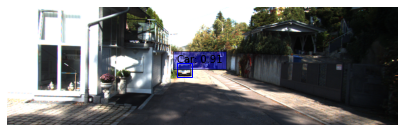

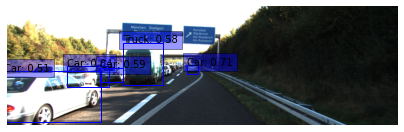

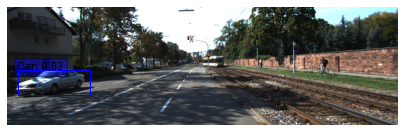

In [75]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(3):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# Project 

### 1. ÏûêÏú®Ï£ºÌñâ ÏãúÏä§ÌÖú ÎßåÎì§Í∏∞
ÏúÑÏóêÏÑú ÎßåÎì† Î™®Îç∏ÏùÑ ÌÜµÌï¥ ÏïÑÎûòÏùò Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥ Ï£ºÏÑ∏Ïöî.

* ÏûÖÎ†•ÏúºÎ°ú Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°úÎ•º Î∞õÏäµÎãàÎã§.
* Ï†ïÏßÄÏ°∞Í±¥Ïóê ÎßûÎäî Í≤ΩÏö∞ "Stop" ÏïÑÎãå Í≤ΩÏö∞ "Go"Î•º Î∞òÌôòÌï©ÎãàÎã§.
* Ï°∞Í±¥ÏùÄ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§.
    * ÏÇ¨ÎûåÏù¥ Ìïú Î™Ö Ïù¥ÏÉÅ ÏûàÎäî Í≤ΩÏö∞
    * Ï∞®ÎüâÏùò ÌÅ¨Í∏∞(width or height)Í∞Ä 300pxÏù¥ÏÉÅÏù∏ Í≤ΩÏö∞

In [76]:
# ÌÅ¥ÎûòÏä§ Î™©Î°ù Ï∂îÏ∂ú
class_names = ds_info.features['objects']['type'].names

# ÌÅ¥ÎûòÏä§ Î™©Î°ù Ï∂úÎ†•
print("KITTI Îç∞Ïù¥ÌÑ∞ÏÖã Í∞ùÏ≤¥ Ïú†Ìòï ÌÅ¥ÎûòÏä§ Î™©Î°ù:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

KITTI Îç∞Ïù¥ÌÑ∞ÏÖã Í∞ùÏ≤¥ Ïú†Ìòï ÌÅ¥ÎûòÏä§ Î™©Î°ù:
0: Car
1: Van
2: Truck
3: Pedestrian
4: Person_sitting
5: Cyclist
6: Tram
7: Misc


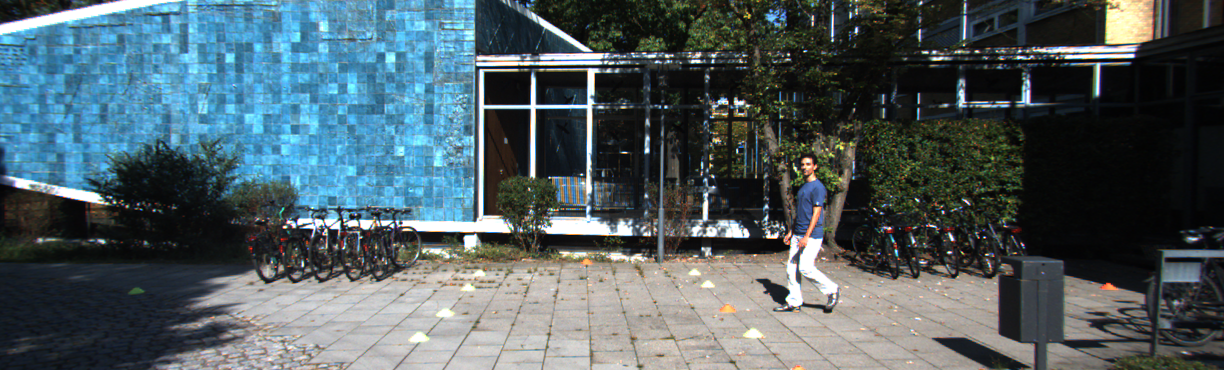

In [77]:
img_path=os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'
img = Image.open(img_path)
img

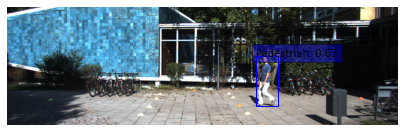

Width: 68.81134033203125, Height: 154.64865112304688
(x_min,y_min,x_max,y_max) = (780.4891, 60.63949, 849.3004, 215.28815)
Stop


In [86]:
def self_drive_assist(img_path, size_limit=300):
    # Load image
    img_raw = tf.io.read_file(img_path)
    image = tf.image.decode_image(img_raw, channels=3)
    
    # Prepare image for model inference
    input_image, ratio = prepare_image(image)
    
    # Perform inference
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    
    # Load KITTI dataset info to convert class integers to strings
    dataset_info = tfds.builder("kitti").info
    int2str = dataset_info.features["objects"]["type"].int2str
    
    # Get detection results
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    
    # Visualize dectection results
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    # Print width and height of the boxes
    for box in boxes:
        width = (box[2] - box[0])
        height = (box[3] - box[1])
        print(f"Width: {width}, Height: {height}")
        print(f'(x_min,y_min,x_max,y_max) = {box[0].numpy(),box[1].numpy(),box[2].numpy(),box[3].numpy()}')
        
    # Check conditions
    person_detected = any(cls in ('Person_sitting', 'Pedestrian', 'Cyclist') for cls in class_names)
    large_vehicle_detected = any(
        (box[2] - box[0]) >= size_limit or (box[3] - box[1]) >= size_limit 
        for cls, box in zip(class_names, boxes) if cls in ['Car', 'Truck', 'Van']
    )

    if person_detected or large_vehicle_detected:
        return 'Stop'
    else:
        return 'Go'


# Test the function with an image path
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_1.png'
print(self_drive_assist(img_path))

### 2. ÏûêÏú®Ï£ºÌñâ ÏãúÏä§ÌÖú ÌèâÍ∞ÄÌïòÍ∏∞
ÏïÑÎûò test_system() Î•º ÌÜµÌï¥ÏÑú ÏúÑÏóêÏÑú ÎßåÎì† Ìï®ÏàòÎ•º ÌèâÍ∞ÄÌï¥Î¥ÖÏãúÎã§.  
10Ïû•Ïóê ÎåÄÌï¥ GoÏôÄ StopÏùÑ ÎßûÍ≤å Î∞òÌôòÌïòÎäîÏßÄ ÌôïÏù∏ÌïòÍ≥† 100Ï†ê ÎßåÏ†êÏúºÎ°ú ÌèâÍ∞ÄÌï¥Ï§çÎãàÎã§.

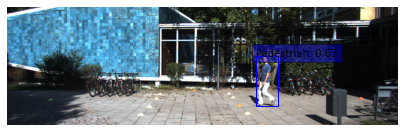

Width: 68.81134033203125, Height: 154.64865112304688
(x_min,y_min,x_max,y_max) = (780.4891, 60.63949, 849.3004, 215.28815)
Stop v. Stop


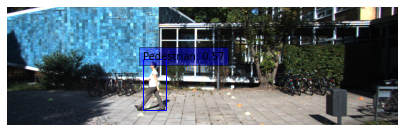

Width: 72.82888793945312, Height: 159.58834838867188
(x_min,y_min,x_max,y_max) = (423.5013, 46.657364, 496.3302, 206.24571)
Stop v. Stop


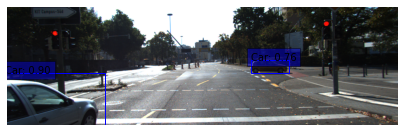

Width: 313.27099609375, Height: 163.16989135742188
(x_min,y_min,x_max,y_max) = (-6.632925, -0.6097618, 306.63806, 162.56013)
Width: 120.60357666015625, Height: 40.12074279785156
(x_min,y_min,x_max,y_max) = (762.4521, 161.98457, 883.05566, 202.10532)
Stop v. Stop


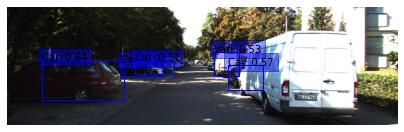

Width: 133.0936279296875, Height: 43.0721435546875
(x_min,y_min,x_max,y_max) = (361.67245, 154.6089, 494.76608, 197.68105)
Width: 260.11541748046875, Height: 125.18814849853516
(x_min,y_min,x_max,y_max) = (111.353745, 80.748924, 371.46915, 205.93707)
Width: 111.26324462890625, Height: 79.34585571289062
(x_min,y_min,x_max,y_max) = (701.8741, 110.38571, 813.1373, 189.73157)
Width: 81.02197265625, Height: 75.35160827636719
(x_min,y_min,x_max,y_max) = (656.81305, 155.57011, 737.835, 230.92172)
Width: 124.6649169921875, Height: 42.883270263671875
(x_min,y_min,x_max,y_max) = (405.07104, 161.31653, 529.73596, 204.1998)
Go v. Stop


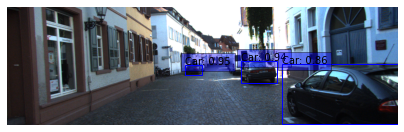

Width: 52.86138916015625, Height: 31.683303833007812
(x_min,y_min,x_max,y_max) = (566.15686, 160.32376, 619.01825, 192.00706)
Width: 113.9566650390625, Height: 71.04878234863281
(x_min,y_min,x_max,y_max) = (744.3864, 132.28186, 858.3431, 203.33064)
Width: 375.5784912109375, Height: 192.3812713623047
(x_min,y_min,x_max,y_max) = (872.20886, 2.93705, 1247.7874, 195.31833)
Stop v. Stop


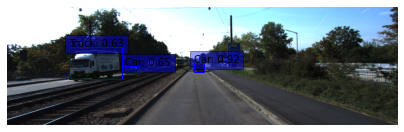

Width: 34.210693359375, Height: 28.68206787109375
(x_min,y_min,x_max,y_max) = (592.4973, 169.4263, 626.708, 198.10837)
Width: 41.748291015625, Height: 22.809036254882812
(x_min,y_min,x_max,y_max) = (375.57803, 165.27217, 417.32632, 188.0812)
Width: 167.60328674316406, Height: 101.81283569335938
(x_min,y_min,x_max,y_max) = (197.0019, 146.51572, 364.6052, 248.32855)
Go v. Go


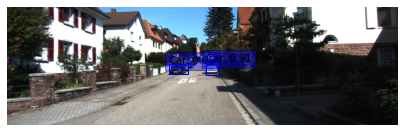

Width: 57.884033203125, Height: 33.069854736328125
(x_min,y_min,x_max,y_max) = (514.9798, 160.53906, 572.86383, 193.60892)
Width: 38.28863525390625, Height: 39.86442565917969
(x_min,y_min,x_max,y_max) = (631.24475, 159.94759, 669.5334, 199.81201)
Go v. Go


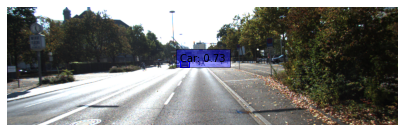

Width: 27.84405517578125, Height: 19.94976806640625
(x_min,y_min,x_max,y_max) = (542.22797, 180.35832, 570.072, 200.30809)
Go v. Go


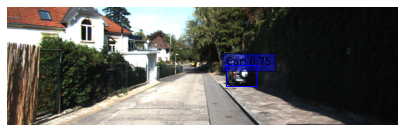

Width: 100.0167236328125, Height: 66.6167984008789
(x_min,y_min,x_max,y_max) = (694.2789, 124.50323, 794.2956, 191.12003)
Go v. Go


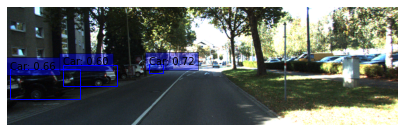

Width: 45.1373291015625, Height: 26.334930419921875
(x_min,y_min,x_max,y_max) = (449.0116, 166.00806, 494.14893, 192.34299)
Width: 221.14125061035156, Height: 93.21376037597656
(x_min,y_min,x_max,y_max) = (9.349659, 83.80748, 230.4909, 177.02124)
Width: 172.11087036132812, Height: 65.16201782226562
(x_min,y_min,x_max,y_max) = (177.01465, 125.25595, 349.12552, 190.41797)
Go v. Go
90Ï†êÏûÖÎãàÎã§.


In [87]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(pred,"v.", answer)
        if pred == answer:
            score += 10
    print(f"{score}Ï†êÏûÖÎãàÎã§.")

test_system(self_drive_assist)

# ÌöåÍ≥†
* Ïù¥Î≤à ProjectÎäî Í∏∞ÌöçÎ∞©Ìñ•Ïù¥ Ï§ëÏöîÌïòÎã§Í≥† ÎäêÍºàÎã§.
* 'class names'Î™©Î°ùÏùÑ Ï∞æÎäî Í≤ÉÏù¥ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú Ï§ëÏöîÌñàÎã§.
* Ï∂îÎ°†ÏùÑ Ï†ÅÏö©ÌïòÎäî Í≥ºÏ†ïÏùÑ ÏïÑÏßÅÎèÑ Ïä§Ïä§Î°úÏóêÍ≤å ÏÑ§Î™ÖÌï† Ïàò ÏóÜÎã§.
* face dectection(project)ÏôÄ ÎπÑÍµêÌïòÎãà ÌôïÏã§Ìûà ÏôÑÏÑ±ÎèÑÍ∞Ä ÎÜíÏùÄ Pre-trained modelÎ•º ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏùò Ìö®Í≥ºÍ∞Ä Ï¢ãÎã§Îäî Í≤ÉÏùÑ ÎäêÍºàÎã§.
* Ï∂îÍ∞ÄÏÇ¨ÏßÑÏùÑ Ï†ÅÏö©ÌïòÎ†§Îäî ÏãúÎèÑÎäî ÏÑ±Í≥µÌïòÏßÄ Î™ªÌñàÎã§.